In [30]:
import nltk
nltk.download('stopwords')

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alien\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [32]:

# Import Dataset
df = pd.read_json('../pre_processed_data.json')

data = df.values.tolist()

for row in data[:10]:
    print(row)

['Raspberry Pi Wi-Fi Raspberry Pi ']
['Raspberry Pi Wi-Fi : Raspberry Pi ping :iperf iperf3 Raspberry Pi Wi-Fi :Raspberry Pi iwconfig Wi-Fi Wi-Fi Analyzer Wi-Fi :Raspberry Pi Wi-Fi :Raspberry Pi dmesg /var/log/syslog vnStat bmon iftop Raspberry Pi Wi-Fi ']
[' Raspberry Pi : ping Raspberry Pi HTTP curl -w : iperf iperf3 Raspberry Pi : : dmesg /var/log/syslog Wi-Fi :Raspberry Pi iwconfig Wi-Fi Wi-Fi Analyzer Wi-Fi CPU :Raspberry Pi top htop CPU : ']
[' ssh ']
[' SSH (Secure Shell)  Raspberry Pi SSH Raspberry Pi iperf curl HTTP URL URL Raspberry Pi Raspberry Pi ']
[' Raspberry Pi :Raspberry Pi 1-4 Wi-Fi : Raspberry Pi / : : : Raspberry Pi CPU top, htop, iftop, nload :Raspberry Pi : Raspberry Pi ']
['iperf Bandwidth :  100 Mbps 1 100 Latency :  ms Jitter :  Packet Loss :  iperf iperf ']
[' iperf :  :  IP 192.168.1.100 :  :  10 1.10 942 Mbits/sec iperf ']
[' iperf iperf :iOS: App Store iPerf iPerf3 Android: Google Play iPerf iPerf3 : iperf -s : iperf IP 5001 : Wi-Fi Wi-Fi ']
[' netstat  : n

In [33]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations


data_words = list(sent_to_words(data))

for row in data_words[:10]:
    print(row)

['raspberry', 'pi', 'wi', 'fi', 'raspberry', 'pi']
['raspberry', 'pi', 'wi', 'fi', 'raspberry', 'pi', 'ping', 'iperf', 'iperf', 'raspberry', 'pi', 'wi', 'fi', 'raspberry', 'pi', 'iwconfig', 'wi', 'fi', 'wi', 'fi', 'analyzer', 'wi', 'fi', 'raspberry', 'pi', 'wi', 'fi', 'raspberry', 'pi', 'dmesg', 'var', 'log', 'syslog', 'vnstat', 'bmon', 'iftop', 'raspberry', 'pi', 'wi', 'fi']
['raspberry', 'pi', 'ping', 'raspberry', 'pi', 'http', 'curl', 'iperf', 'iperf', 'raspberry', 'pi', 'dmesg', 'var', 'log', 'syslog', 'wi', 'fi', 'raspberry', 'pi', 'iwconfig', 'wi', 'fi', 'wi', 'fi', 'analyzer', 'wi', 'fi', 'cpu', 'raspberry', 'pi', 'top', 'htop', 'cpu']
['ssh']
['ssh', 'secure', 'shell', 'raspberry', 'pi', 'ssh', 'raspberry', 'pi', 'iperf', 'curl', 'http', 'url', 'url', 'raspberry', 'pi', 'raspberry', 'pi']
['raspberry', 'pi', 'raspberry', 'pi', 'wi', 'fi', 'raspberry', 'pi', 'raspberry', 'pi', 'cpu', 'top', 'htop', 'iftop', 'nload', 'raspberry', 'pi', 'raspberry', 'pi']
['iperf', 'bandwidth', 'm

In [34]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
for trigram in trigram_mod[bigram_mod[data_words[:10]]]:
    print(trigram)

['raspberry_pi', 'wi_fi_raspberry_pi']
['raspberry_pi', 'wi_fi_raspberry_pi', 'ping', 'iperf_iperf', 'raspberry_pi', 'wi_fi_raspberry_pi', 'iwconfig', 'wi_fi', 'wi_fi', 'analyzer', 'wi_fi_raspberry_pi', 'wi_fi_raspberry_pi', 'dmesg', 'var', 'log', 'syslog', 'vnstat', 'bmon', 'iftop', 'raspberry_pi', 'wi_fi']
['raspberry_pi', 'ping', 'raspberry_pi', 'http', 'curl', 'iperf_iperf', 'raspberry_pi', 'dmesg', 'var', 'log', 'syslog', 'wi_fi_raspberry_pi', 'iwconfig', 'wi_fi', 'wi_fi', 'analyzer', 'wi_fi', 'cpu', 'raspberry_pi', 'top', 'htop', 'cpu']
['ssh']
['ssh', 'secure', 'shell', 'raspberry_pi', 'ssh', 'raspberry_pi', 'iperf', 'curl', 'http', 'url', 'url', 'raspberry_pi', 'raspberry_pi']
['raspberry_pi', 'raspberry_pi', 'wi_fi_raspberry_pi', 'raspberry_pi', 'cpu', 'top', 'htop', 'iftop', 'nload', 'raspberry_pi', 'raspberry_pi']
['iperf', 'bandwidth', 'mbps', 'latency', 'ms', 'jitter', 'packet', 'loss', 'iperf_iperf']
['iperf', 'ip', 'mbits', 'sec', 'iperf']
['iperf_iperf', 'ios', 'app', '

In [35]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


In [36]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# print
for row in data_words_bigrams[:10]:
    print(row)

['raspberry_pi', 'wi_fi', 'raspberry_pi']
['raspberry_pi', 'wi_fi', 'raspberry_pi', 'ping', 'iperf_iperf', 'raspberry_pi', 'wi_fi', 'raspberry_pi', 'iwconfig', 'wi_fi', 'wi_fi', 'analyzer', 'wi_fi', 'raspberry_pi', 'wi_fi', 'raspberry_pi', 'dmesg', 'var', 'log', 'syslog', 'vnstat', 'bmon', 'iftop', 'raspberry_pi', 'wi_fi']
['raspberry_pi', 'ping', 'raspberry_pi', 'http', 'curl', 'iperf_iperf', 'raspberry_pi', 'dmesg', 'var', 'log', 'syslog', 'wi_fi', 'raspberry_pi', 'iwconfig', 'wi_fi', 'wi_fi', 'analyzer', 'wi_fi', 'cpu', 'raspberry_pi', 'top', 'htop', 'cpu']
['ssh']
['ssh', 'secure', 'shell', 'raspberry_pi', 'ssh', 'raspberry_pi', 'iperf', 'curl', 'http', 'url', 'url', 'raspberry_pi', 'raspberry_pi']
['raspberry_pi', 'raspberry_pi', 'wi_fi', 'raspberry_pi', 'raspberry_pi', 'cpu', 'top', 'htop', 'iftop', 'nload', 'raspberry_pi', 'raspberry_pi']
['iperf', 'bandwidth', 'mbps', 'latency', 'ms', 'jitter', 'packet', 'loss', 'iperf_iperf']
['iperf', 'ip', 'mbits', 'sec', 'iperf']
['iperf_ip

In [37]:
!python -m spacy download en_core_web_sm

     --------------------------------------- 12.8/12.8 MB 34.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [38]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [39]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

for row in data_lemmatized[:10]:
    print(row)

[]
['log', 'syslog']
['log', 'syslog', 'cpu', 'top', 'htop', 'cpu']
[]
['secure']
[]
['loss']
['iperf']
['iperf_iperf', 'app', 'store', 'play', 'ip']
['netstat', 'netstat', 'copy', 'codenetstat', 'tuln', 'netstat', 'copy', 'codess', 'tuln', 'list', 'open', 'file', 'csscopy', 'csscopy', 'codelsof', 'grep', 'listen']


In [40]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

corpus = [doc for doc in corpus if len(doc)>1]

for row in corpus[:10]:
    print(row)

[(0, 1), (1, 1)]
[(0, 1), (1, 1), (2, 2), (3, 1), (4, 1)]
[(8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]
[(13, 1), (14, 1), (15, 1), (16, 2), (17, 2), (18, 1), (19, 1), (20, 1), (21, 1), (22, 3), (23, 1), (24, 2)]
[(25, 2), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 3), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 2), (80, 1), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 2), (91, 1), (92, 2), (93, 3), (94, 8), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 9), (101, 2), (102, 1), (103, 2), (104, 3), (105, 2), (106, 1), (107, 1), (108, 2), (109, 1), (110, 1), (11

In [41]:
# Human readable format of corpus (term-frequency)
for row in [[(id2word[id], freq) for id, freq in cp] for cp in corpus[:10]]:
    print(row)

[('log', 1), ('syslog', 1)]
[('log', 1), ('syslog', 1), ('cpu', 2), ('htop', 1), ('top', 1)]
[('app', 1), ('ip', 1), ('iperf_iperf', 1), ('play', 1), ('store', 1)]
[('codelsof', 1), ('codenetstat', 1), ('codess', 1), ('copy', 2), ('csscopy', 2), ('file', 1), ('grep', 1), ('list', 1), ('listen', 1), ('netstat', 3), ('open', 1), ('tuln', 2)]
[('address', 2), ('advancement', 1), ('ai', 1), ('always', 2), ('artificial_intelligence', 1), ('base', 1), ('bing', 1), ('bridge', 1), ('capability', 1), ('casestudie', 1), ('category', 1), ('collaboration', 1), ('concise', 1), ('consistent', 1), ('create', 1), ('creation', 1), ('current', 1), ('delivering', 1), ('desire', 1), ('disparity', 1), ('drive', 1), ('education', 1), ('educational', 1), ('educator', 1), ('effective', 1), ('effort', 1), ('experience', 1), ('expert', 1), ('fall', 1), ('focus', 1), ('follow', 1), ('format', 1), ('funder', 1), ('gap', 1), ('general', 1), ('generate', 1), ('generator', 1), ('good', 1), ('google', 1), ('governmen

In [42]:
# # Build LDA model
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=20, 
#                                            random_state=100,
#                                            update_every=1,
#                                            chunksize=100,
#                                            passes=10,
#                                            alpha='auto',
#                                            per_word_topics=True)

# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=16,  # Updated number of topics
#                                            random_state=100,  # Keeping as it is
#                                            update_every=1,  # Keeping as it is
#                                            chunksize=100,  # Keeping as it is
#                                            passes=2000,  # Updated, but you might want to tweak this based on your corpus
#                                            alpha=50/16,  # Updated alpha
#                                            eta=0.01,  # Updated beta, using eta as the parameter name
#                                            per_word_topics=True)  # Keeping as it is

In [43]:
# Print the Keyword in the 10 topics
# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [44]:
# Visualize the topics
# pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
# vis

In [45]:
import importlib
import ldamallet
importlib.reload(ldamallet)
import os

In [46]:
mallet_dir =  os.getcwd() + '/mallet-2.0.8/'
mallet_path =  mallet_dir + 'bin/mallet.bat'

In [47]:
os.environ['MALLET_HOME'] = mallet_dir

In [48]:
# Initializing the LdaMallet model
ldamalletmodel = ldamallet.LdaMallet(mallet_path,
                    corpus=corpus,
                    num_topics=16,  # Setting number of topics as 16 (K=16)
                    id2word=id2word,
                    alpha=50/16,  # Setting alpha as 50/K
                    iterations=2000)  # Setting iterations as 2000 (Ir=2000)

# Show Topics
pprint(ldamalletmodel.show_topics(formatted=False))

[(4,
  [('model', 0.0828447134480802),
   ('language', 0.01777945905050123),
   ('datum', 0.017401172687724606),
   ('student', 0.012578021562322678),
   ('service', 0.011537734064686968),
   ('text', 0.010402874976357102),
   ('test', 0.009551730660109703),
   ('lesson', 0.008700586343862303),
   ('database', 0.008416871571779838),
   ('create', 0.008133156799697372)]),
 (7,
  [('string', 0.033313280192510154),
   ('return', 0.020078207249210406),
   ('include', 0.018198225297037147),
   ('line', 0.017671830350428637),
   ('match', 0.01413746428034291),
   ('function', 0.013535870055647466),
   ('element', 0.012708677996691231),
   ('option', 0.010979094600691833),
   ('int', 0.010452699654083322),
   ('update', 0.0101519025417356)]),
 (5,
  [('class', 0.03895116853505605),
   ('return', 0.023940718221546645),
   ('public', 0.02365570967129014),
   ('model', 0.017480524415732474),
   ('loss', 0.017195515865475963),
   ('inputs_embed', 0.013585407562226866),
   ('def', 0.01244537336120

In [49]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamalletmodel, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4521411737457941


In [50]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamallet.malletmodel2ldamodel(ldamalletmodel), corpus, id2word)
vis

c:\Users\alien\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\alien\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\alien\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
12    -0.252172  0.082756       1        1  11.504477
10     0.096596  0.162000       2        1   9.934339
11     0.115027 -0.107028       3        1   8.708874
15     0.022694 -0.233630       4        1   8.021676
8     -0.263906 -0.101440       5        1   7.433641
5     -0.198419  0.116910       6        1   6.721617
2      0.074958  0.122337       7        1   6.554284
9      0.161116 -0.027786       8        1   6.256651
3     -0.136813 -0.109381       9        1   5.034790
1     -0.085647 -0.140482      10        1   4.869482
6      0.041400  0.148107      11        1   4.811192
0      0.176468 -0.155982      12        1   4.744709
4      0.055997  0.007793      13        1   4.531791
7     -0.110878  0.063481      14        1   4.247235
14     0.104424  0.198003      15        1   3.857804
13     0.199157 -0.025658      16        1   2.767435, topic_info=         Term         Freq        Total Category  logprob  loglift
18       file  3574.000000  3574.000000  Default  30.0000  30.0000
2044    model  2369.000000  2369.000000  Default  29.0000  29.0000
2069     item  1875.000000  1875.000000  Default  28.0000  28.0000
903      user  1285.000000  1285.000000  Default  27.0000  27.0000
714     error  1455.000000  1455.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
328      find    37.684246   528.502143  Topic16  -5.2299   0.9464
73      issue    37.684246   563.541335  Topic16  -5.2299   0.8823
30       base    38.036435   791.451888  Topic16  -5.2206   0.5519
121      case    33.105786   347.700940  Topic16  -5.3594   1.2356
815   content    32.401408  1113.994286  Topic16  -5.3809   0.0497

[1460 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
879        1  0.708480             _
879        2  0.261830             _
879       12  0.030803             _
184        3  0.031233       ability
184        8  0.843289       ability
...      ...       ...           ...
5568      11  0.022032       youtube
4215       9  0.987649           zip
4215      11  0.020156           zip
13144     11  1.006343  zip_download
1783      13  0.917417           zoo

[2613 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 11, 12, 16, 9, 6, 3, 10, 4, 2, 7, 1, 5, 8, 15, 14])

In [51]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3, iterations=2000):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = ldamallet.LdaMallet(mallet_path,
                            corpus=corpus,
                            num_topics=16,  # Setting number of topics as 16 (K=16)
                            id2word=id2word,
                            iterations=iterations)
        model = ldamallet.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [52]:
import pickle

limit=51; start=2; step=1;
ir_values = [100, 500, 1000, 2000]

if os.path.exists('all_model_list') and os.path.exists('all_coherence_values'):
    # read all_model_list
    with open('all_model_list', 'rb') as f:
        all_model_list = pickle.load(f)

    # read all_coherence_values
    with open('all_coherence_values', 'rb') as f:
        all_coherence_values = pickle.load(f)
else:
    all_coherence_values = []
    all_model_list = []
    for ir in ir_values:
        model_list, coherence_values = compute_coherence_values(
            dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
            start=start, limit=limit, step=step, iterations=ir)
        all_coherence_values.append(coherence_values)
        all_model_list.append(model_list)

    with open('all_coherence_values', 'wb') as fp:
        pickle.dump(all_coherence_values, fp)

    with open('all_model_list', 'wb') as fp:
        pickle.dump(all_model_list, fp)

Itrations = 100
Num Topics = 2  has Coherence Value of 0.4591
Num Topics = 3  has Coherence Value of 0.4604
Num Topics = 4  has Coherence Value of 0.5046
Num Topics = 5  has Coherence Value of 0.4787
Num Topics = 6  has Coherence Value of 0.5148
Num Topics = 7  has Coherence Value of 0.471
Num Topics = 8  has Coherence Value of 0.4811
Num Topics = 9  has Coherence Value of 0.4578
Num Topics = 10  has Coherence Value of 0.4715
Num Topics = 11  has Coherence Value of 0.4423
Num Topics = 12  has Coherence Value of 0.467
Num Topics = 13  has Coherence Value of 0.4663
Num Topics = 14  has Coherence Value of 0.4813
Num Topics = 15  has Coherence Value of 0.469
Num Topics = 16  has Coherence Value of 0.446
Num Topics = 17  has Coherence Value of 0.4733
Num Topics = 18  has Coherence Value of 0.42
Num Topics = 19  has Coherence Value of 0.4658
Num Topics = 20  has Coherence Value of 0.4772
Num Topics = 21  has Coherence Value of 0.4899
Num Topics = 22  has Coherence Value of 0.4897
Num Topics 

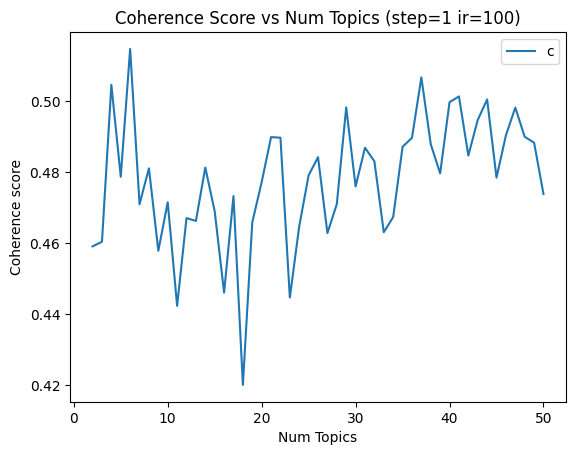

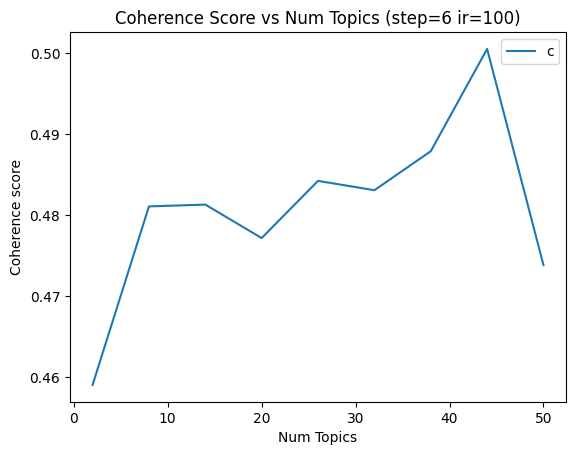


Itrations = 500
Num Topics = 2  has Coherence Value of 0.4199
Num Topics = 3  has Coherence Value of 0.4763
Num Topics = 4  has Coherence Value of 0.461
Num Topics = 5  has Coherence Value of 0.4934
Num Topics = 6  has Coherence Value of 0.4468
Num Topics = 7  has Coherence Value of 0.4867
Num Topics = 8  has Coherence Value of 0.4739
Num Topics = 9  has Coherence Value of 0.4253
Num Topics = 10  has Coherence Value of 0.4656
Num Topics = 11  has Coherence Value of 0.4657
Num Topics = 12  has Coherence Value of 0.4758
Num Topics = 13  has Coherence Value of 0.439
Num Topics = 14  has Coherence Value of 0.4556
Num Topics = 15  has Coherence Value of 0.4633
Num Topics = 16  has Coherence Value of 0.4709
Num Topics = 17  has Coherence Value of 0.4783
Num Topics = 18  has Coherence Value of 0.4661
Num Topics = 19  has Coherence Value of 0.4793
Num Topics = 20  has Coherence Value of 0.4655
Num Topics = 21  has Coherence Value of 0.4861
Num Topics = 22  has Coherence Value of 0.4695
Num To

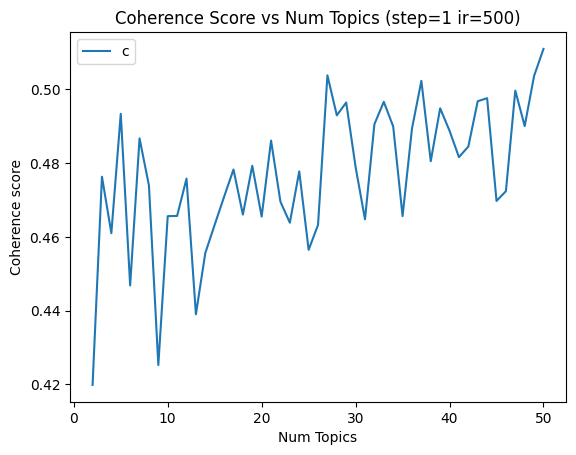

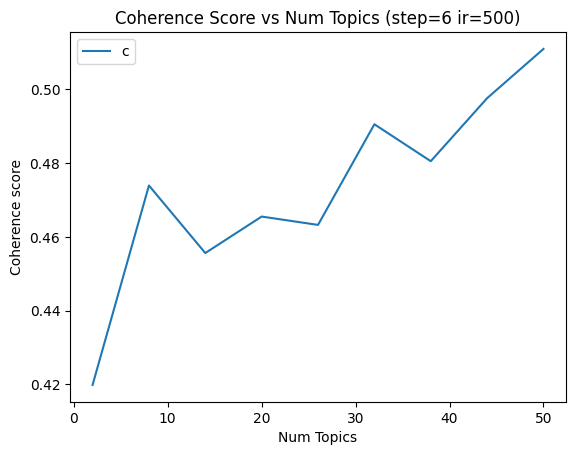


Itrations = 1000
Num Topics = 2  has Coherence Value of 0.4593
Num Topics = 3  has Coherence Value of 0.4478
Num Topics = 4  has Coherence Value of 0.4664
Num Topics = 5  has Coherence Value of 0.4965
Num Topics = 6  has Coherence Value of 0.4421
Num Topics = 7  has Coherence Value of 0.4486
Num Topics = 8  has Coherence Value of 0.4441
Num Topics = 9  has Coherence Value of 0.4467
Num Topics = 10  has Coherence Value of 0.4696
Num Topics = 11  has Coherence Value of 0.4659
Num Topics = 12  has Coherence Value of 0.4899
Num Topics = 13  has Coherence Value of 0.4679
Num Topics = 14  has Coherence Value of 0.46
Num Topics = 15  has Coherence Value of 0.4444
Num Topics = 16  has Coherence Value of 0.4468
Num Topics = 17  has Coherence Value of 0.4706
Num Topics = 18  has Coherence Value of 0.4668
Num Topics = 19  has Coherence Value of 0.4873
Num Topics = 20  has Coherence Value of 0.4801
Num Topics = 21  has Coherence Value of 0.4744
Num Topics = 22  has Coherence Value of 0.4667
Num T

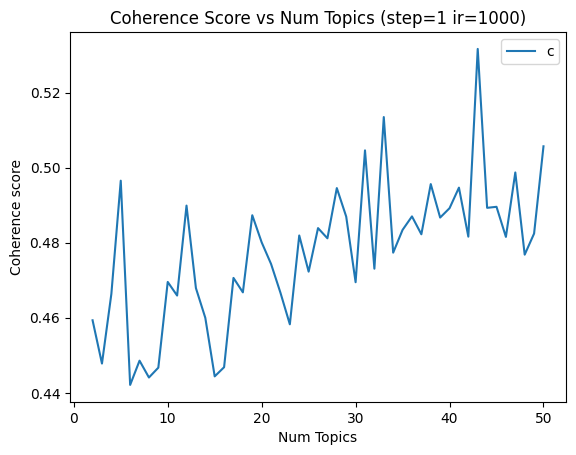

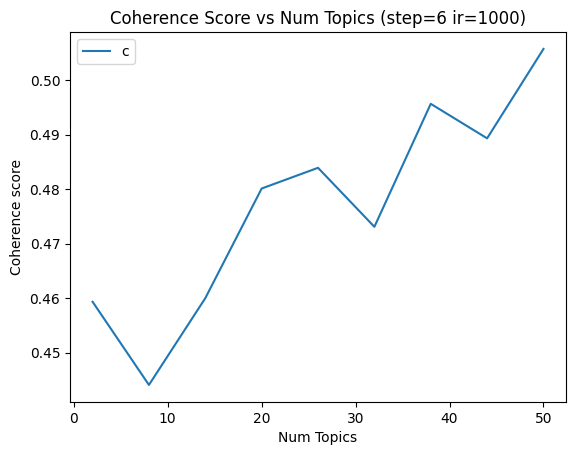


Itrations = 2000
Num Topics = 2  has Coherence Value of 0.4439
Num Topics = 3  has Coherence Value of 0.4676
Num Topics = 4  has Coherence Value of 0.4828
Num Topics = 5  has Coherence Value of 0.4734
Num Topics = 6  has Coherence Value of 0.4615
Num Topics = 7  has Coherence Value of 0.4735
Num Topics = 8  has Coherence Value of 0.4895
Num Topics = 9  has Coherence Value of 0.4731
Num Topics = 10  has Coherence Value of 0.4593
Num Topics = 11  has Coherence Value of 0.496
Num Topics = 12  has Coherence Value of 0.4597
Num Topics = 13  has Coherence Value of 0.4864
Num Topics = 14  has Coherence Value of 0.4689
Num Topics = 15  has Coherence Value of 0.4487
Num Topics = 16  has Coherence Value of 0.4628
Num Topics = 17  has Coherence Value of 0.4775
Num Topics = 18  has Coherence Value of 0.4666
Num Topics = 19  has Coherence Value of 0.4558
Num Topics = 20  has Coherence Value of 0.4676
Num Topics = 21  has Coherence Value of 0.4906
Num Topics = 22  has Coherence Value of 0.4967
Num 

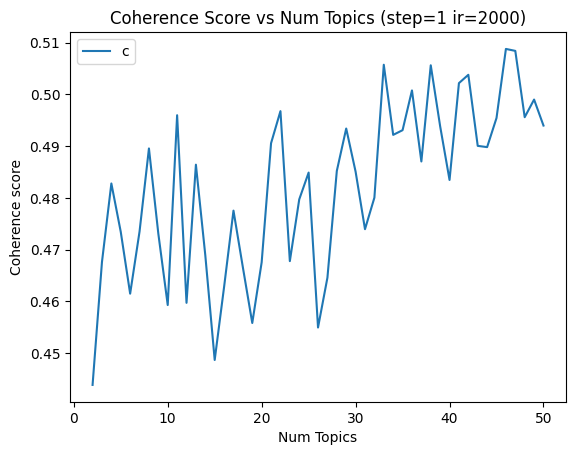

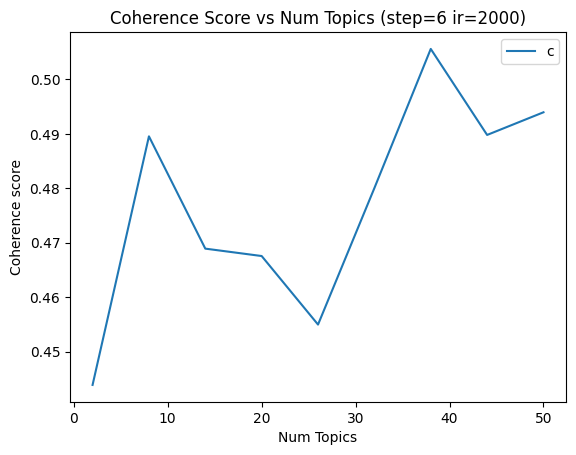

In [53]:
for i in range(len(ir_values)):
    ir = ir_values[i]
    coherence_values = all_coherence_values[i]
    x = range(start, limit, step)
    print("Itrations = {}".format(ir))
    for m, cv in zip(x, all_coherence_values[i]):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    print()
    
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.title('Coherence Score vs Num Topics (step={} ir={})'.format(step, ir))
    plt.show()

    x_step = 6
    x = range(start, limit, x_step)
    plt.plot(x, coherence_values[::x_step])
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.title('Coherence Score vs Num Topics (step={} ir={})'.format(x_step, ir))
    plt.show()

    print()

In [54]:
# Initializing the LdaMallet model
ldamalletmodel35 = ldamallet.LdaMallet(mallet_path,
                    corpus=corpus,
                    num_topics=35,  
                    id2word=id2word,
                    alpha=50/35,  
                    iterations=2000) 

# Show Topics
pprint(ldamalletmodel.show_topics(formatted=False))

[(8,
  [('file', 0.09005405405405405),
   ('error', 0.03794594594594595),
   ('model', 0.03286486486486487),
   ('py_line', 0.028324324324324326),
   ('transformer', 0.020216216216216217),
   ('site_package', 0.016972972972972972),
   ('users_rensantheworld', 0.015783783783783784),
   ('return', 0.015243243243243243),
   ('import', 0.01372972972972973),
   ('src', 0.01254054054054054)]),
 (12,
  [('item', 0.06279834517874192),
   ('title', 0.028110745730348996),
   ('def', 0.026731728015275274),
   ('return', 0.024822318871327038),
   ('content', 0.024079770870902725),
   ('response', 0.022382518298504295),
   ('result', 0.019518404582581944),
   ('text', 0.018457621724832927),
   ('import', 0.018139386867508222),
   ('image', 0.017821152010183517)]),
 (9,
  [('user', 0.05358956992888588),
   ('security', 0.014900101591601761),
   ('email', 0.014222824246528954),
   ('time', 0.011175076193701321),
   ('context', 0.010413139180494413),
   ('provide', 0.010243819844226211),
   ('rustup_t

In [55]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamalletmodel35, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.485605003954166


In [56]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamallet.malletmodel2ldamodel(ldamalletmodel35), corpus, id2word)
vis

c:\Users\alien\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\alien\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
c:\Users\alien\anaconda3\lib\site-packages\pandas\core\internals\blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
12     0.066906  0.069236       1        1  7.123616
18    -0.100464  0.122250       2        1  6.841948
2     -0.108520 -0.084296       3        1  6.600334
25    -0.027385  0.146936       4        1  6.204237
16     0.268550  0.054699       5        1  4.653785
27     0.040810  0.086315       6        1  4.538873
15    -0.017487 -0.234297       7        1  4.445423
11     0.241505  0.016884       8        1  3.798119
0     -0.121397  0.147952       9        1  3.651665
10     0.094122 -0.079913      10        1  3.634589
13    -0.088475  0.127981      11        1  3.604259
20     0.165154  0.005776      12        1  3.592891
21     0.022635 -0.189273      13        1  3.470358
17     0.137251  0.016613      14        1  3.464979
7     -0.057223  0.072787      15        1  3.160074
23    -0.112077 -0.112923      16        1  2.876995
6     -0.020754 -0.203955      17        1  2.387119
32     0.056401 -0.206113      18        1  2.290980
4      0.031165  0.022387      19        1  2.081075
19    -0.086236 -0.100034      20        1  1.993220
30    -0.085623 -0.044577      21        1  1.943737
5     -0.167158 -0.112029      22        1  1.892103
26     0.101880  0.026015      23        1  1.814709
24    -0.076542  0.033680      24        1  1.812405
3     -0.205630 -0.044681      25        1  1.784750
31     0.074836  0.056736      26        1  1.626153
34     0.240084 -0.040859      27        1  1.596286
14     0.008695 -0.051334      28        1  1.439706
29    -0.180753  0.037613      29        1  1.403577
22     0.000412 -0.109167      30        1  1.143056
1     -0.039110  0.136434      31        1  0.968069
28    -0.001796  0.051602      32        1  0.608046
9      0.161957  0.115137      33        1  0.555836
33    -0.091788  0.137559      34        1  0.530680
8     -0.123942  0.128859      35        1  0.466346, topic_info=          Term         Freq        Total Category  logprob  loglift
2044     model  2634.000000  2634.000000  Default  30.0000  30.0000
18        file  3353.000000  3353.000000  Default  29.0000  29.0000
2069      item  1341.000000  1341.000000  Default  28.0000  28.0000
644      datum  1613.000000  1613.000000  Default  27.0000  27.0000
684     return  1654.000000  1654.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
165    project     7.753976   582.397505  Topic35  -5.0302   1.0491
95    question     6.605239   118.157514  Topic35  -5.1905   2.4838
2864      year     6.318055    89.780916  Topic35  -5.2350   2.7140
170       role     6.030871    53.067525  Topic35  -5.2815   3.1933
1307     field     6.030871   199.590932  Topic35  -5.2815   1.8686

[3131 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
879        5  0.626330             _
879        9  0.306048             _
879       16  0.053380             _
879       19  0.007117             _
879       32  0.007117             _
...      ...       ...           ...
4215      27  0.030524           zip
4215      32  0.030524           zip
13144      8  0.998655  zip_download
1783      35  1.741042           zoo
4978      10  0.973474          zoom

[6258 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[13, 19, 3, 26, 17, 28, 16, 12, 1, 11, 14, 21, 22, 18, 8, 24, 7, 33, 5, 20, 31, 6, 27, 25, 4, 32, 35, 15, 30, 23, 2, 29, 10, 34, 9])

In [77]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Store the topics, contributions, and keywords for each document in lists
    topics_data = []
    
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        if len(row_list) == 0:
            # Handle the case where a document doesn't have a topic distribution
            continue
        
        # Sort the topics by contribution and take the dominant topic
        row_list = sorted(row_list, key=lambda x: (x[1]), reverse=True)
        dominant_topic_num, dominant_prop_topic = row_list[0]
        
        # Get the topic keywords
        topic_keywords = ", ".join([word for word, prop in ldamodel.show_topic(dominant_topic_num)])
        
        # Append the data to the list
        topics_data.append((dominant_topic_num, id2word[dominant_topic_num], round(dominant_prop_topic, 4), topic_keywords))
    
    # Create a DataFrame from the collected data
    if topics_data:
        sent_topics_df = pd.DataFrame(topics_data, columns=['Dominant_Topic_Num', 'Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords'])
    
    # Add original text to the end of the output
    if not sent_topics_df.empty:
        sent_topics_df['Text'] = pd.Series(texts)
    
    return sent_topics_df

In [86]:
df_topic_sents_keywords = format_topics_sentences(ldamalletmodel, corpus, data)

In [93]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic_Num', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# drop document_no column
df_dominant_topic = df_dominant_topic.drop(columns=['Document_No'])
# Show
df_dominant_topic.head(10)

,Dominant_Topic_Num,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,32,bridge,0.5366,"run, command, container, server, script, docke...",[Raspberry Pi Wi-Fi Raspberry Pi ]
1,32,bridge,0.6481,"run, command, container, server, script, docke...",[Raspberry Pi Wi-Fi : Raspberry Pi ping :iperf...
2,23,open,0.3972,"network, port, server, connection, socket, int...",[ Raspberry Pi : ping Raspberry Pi HTTP curl -...
3,10,iperf_iperf,0.8369,"page, image, web, file, element, update, creat...",[ ssh ]
4,8,app,0.3347,"source, result, student, link, security, match...",[ SSH (Secure Shell) Raspberry Pi SSH Raspber...
5,18,file,0.3848,"feature, learn, class, literacy, sound, health...",[ Raspberry Pi :Raspberry Pi 1-4 Wi-Fi : Raspb...
6,18,file,0.6679,"feature, learn, class, literacy, sound, health...",[iperf Bandwidth : 100 Mbps 1 100 Latency : ...
7,19,grep,0.5211,"file, datum, provide, code, content, structure...",[ iperf : : IP 192.168.1.100 : : 10 1.10 9...
8,11,play,0.3094,"text, def, return, list, true, import, key, up...",[ iperf iperf :iOS: App Store iPerf iPerf3 And...
9,11,play,0.4641,"text, def, return, list, true, import, key, up...",[ netstat : netstat Copy codenetstat -tuln ss...


In [94]:
# save to csv
df_dominant_topic.to_csv('./output/dominant_topics_16.csv')

In [95]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic_Num')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(10)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic", "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic,Topic_Perc_Contrib,Keywords,Text
0,0,log,0.9842,"datum, group, give, test, number, beta, distri...",[Do I have to do anything else to ensure it s ...
1,0,log,0.9839,"datum, group, give, test, number, beta, distri...",[Auf der Seite haben wir das gleiche Problem....
2,0,log,0.9833,"datum, group, give, test, number, beta, distri...","[How do I create libraries in node, and how do..."
3,0,log,0.9833,"datum, group, give, test, number, beta, distri...",[If I have the name as String?]
4,0,log,0.9815,"datum, group, give, test, number, beta, distri...",[There isn't a simple way to directly calculat...
...,...,...,...,...,...
345,34,casestudie,0.9262,"file, import, py_line, object, lib_site, modul...",[Running a Python file directly within an HTML...
346,34,casestudie,0.9245,"file, import, py_line, object, lib_site, modul...",[Sure! Point 3 refers to hosting Jupyter Noteb...
347,34,casestudie,0.8681,"file, import, py_line, object, lib_site, modul...",[how to put python code in websit]
348,34,casestudie,0.8664,"file, import, py_line, object, lib_site, modul...","[ (React) Facebook UI , ..."


In [96]:
# save to csv
sent_topics_sorteddf_mallet.to_csv('./output/top10_sentences_16.csv')

In [87]:
df_topic_sents_keywords = format_topics_sentences(ldamalletmodel35, corpus, data)

In [97]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic_Num', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
# drop document_no column
df_dominant_topic = df_dominant_topic.drop(columns=['Document_No'])
# Show
df_dominant_topic.head(10)

,Dominant_Topic_Num,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,32,bridge,0.5366,"run, command, container, server, script, docke...",[Raspberry Pi Wi-Fi Raspberry Pi ]
1,32,bridge,0.6481,"run, command, container, server, script, docke...",[Raspberry Pi Wi-Fi : Raspberry Pi ping :iperf...
2,23,open,0.3972,"network, port, server, connection, socket, int...",[ Raspberry Pi : ping Raspberry Pi HTTP curl -...
3,10,iperf_iperf,0.8369,"page, image, web, file, element, update, creat...",[ ssh ]
4,8,app,0.3347,"source, result, student, link, security, match...",[ SSH (Secure Shell) Raspberry Pi SSH Raspber...
5,18,file,0.3848,"feature, learn, class, literacy, sound, health...",[ Raspberry Pi :Raspberry Pi 1-4 Wi-Fi : Raspb...
6,18,file,0.6679,"feature, learn, class, literacy, sound, health...",[iperf Bandwidth : 100 Mbps 1 100 Latency : ...
7,19,grep,0.5211,"file, datum, provide, code, content, structure...",[ iperf : : IP 192.168.1.100 : : 10 1.10 9...
8,11,play,0.3094,"text, def, return, list, true, import, key, up...",[ iperf iperf :iOS: App Store iPerf iPerf3 And...
9,11,play,0.4641,"text, def, return, list, true, import, key, up...",[ netstat : netstat Copy codenetstat -tuln ss...


In [101]:
# save to csv
df_dominant_topic.to_csv('./output/dominant_topics_35.csv')

In [99]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic_Num')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(10)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic", "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic,Topic_Perc_Contrib,Keywords,Text
0,0,log,0.9842,"datum, group, give, test, number, beta, distri...",[Do I have to do anything else to ensure it s ...
1,0,log,0.9839,"datum, group, give, test, number, beta, distri...",[Auf der Seite haben wir das gleiche Problem....
2,0,log,0.9833,"datum, group, give, test, number, beta, distri...","[How do I create libraries in node, and how do..."
3,0,log,0.9833,"datum, group, give, test, number, beta, distri...",[If I have the name as String?]
4,0,log,0.9815,"datum, group, give, test, number, beta, distri...",[There isn't a simple way to directly calculat...
...,...,...,...,...,...
345,34,casestudie,0.9262,"file, import, py_line, object, lib_site, modul...",[Running a Python file directly within an HTML...
346,34,casestudie,0.9245,"file, import, py_line, object, lib_site, modul...",[Sure! Point 3 refers to hosting Jupyter Noteb...
347,34,casestudie,0.8681,"file, import, py_line, object, lib_site, modul...",[how to put python code in websit]
348,34,casestudie,0.8664,"file, import, py_line, object, lib_site, modul...","[ (React) Facebook UI , ..."


In [100]:
# save sent_topics_sorteddf_mallet in csv
sent_topics_sorteddf_mallet.to_csv('./output/top10_sentences_35.csv')